# 05/11/03 - Estudos da difusão-reacao


## Resumo

- Função de perda: RMSE
- Funções de  ativação: 
    - Tanh/SiLu

- Tamanhos de batelada:
    - 1.2e3

- Numero de épocas:
    - 1e5

- Arquivo de checkpoint: 
    - 

- Peso da perda de pde: 1
- Peso da perda de incial: 1


## Análise de erro vs speedup

In [1]:
import glob
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [2]:
result_list = glob.glob("pinn_sim/output_*")

print("numero de arquiteturas testadas: {}".format(len(result_list)))

numero de arquiteturas testadas: 1


In [3]:
i = 0

results_dict = {}

retrieve_betas = lambda beta: beta.split("_")[-1]

for file in result_list:
    with open(file, "rb") as f:
        aux_dict = pk.load(f)

    if not np.isnan(aux_dict["rmse"]):

        results_dict[i] = aux_dict

        results_dict[i]["file"] = file.split("pinn_sim/output_")[-1]

        layers_list = file.split("/")[-1].split(".pkl")[0].split("__")[2:]

        results_dict[i]["betas"] = ("__").join(
            list(
                map(
                    retrieve_betas, file.split("/")[-1].split(".pkl")[0].split("__")[:2]
                )
            )
        )

        results_dict[i]["arch_name"] = ("__").join(layers_list)

        results_dict[i]["n_layers"] = len(layers_list)

        n_neurons = 0

        for layer in layers_list:

            n_neurons += int(layer.split("--")[-1])

        results_dict[i]["n_neurons"] = n_neurons

        results_dict[i]["n_layers"] = len(layers_list)

        i += 1

In [4]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index")

results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 0 to 0
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_speed_up       1 non-null      float64
 1   std_speed_up        1 non-null      float64
 2   mean_speed_comp_up  1 non-null      float64
 3   std_speed_comp_up   1 non-null      float64
 4   mean_speed_up_pinn  1 non-null      float64
 5   std_speed_up_pinn   1 non-null      float64
 6   mean_serial_time    1 non-null      float64
 7   std_serial_time     1 non-null      float64
 8   mean_cuda_time      1 non-null      float64
 9   std_cuda_time       1 non-null      float64
 10  mean_pinn_time      1 non-null      float64
 11  std_pinn_time       1 non-null      float64
 12  rmse                1 non-null      float64
 13  max_ae              1 non-null      float64
 14  file                1 non-null      object 
 15  betas               1 non-null      object 
 16  arch_name        

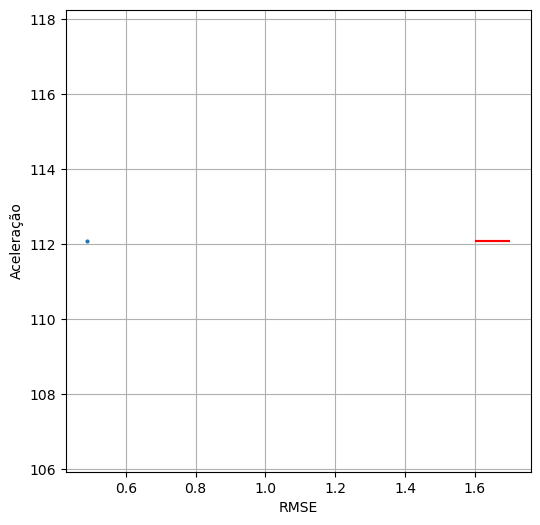

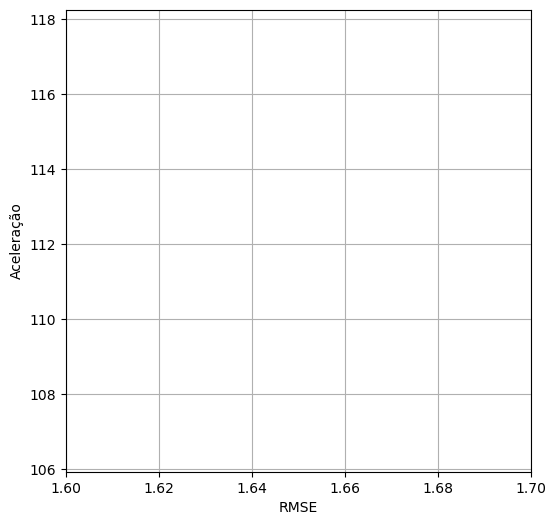

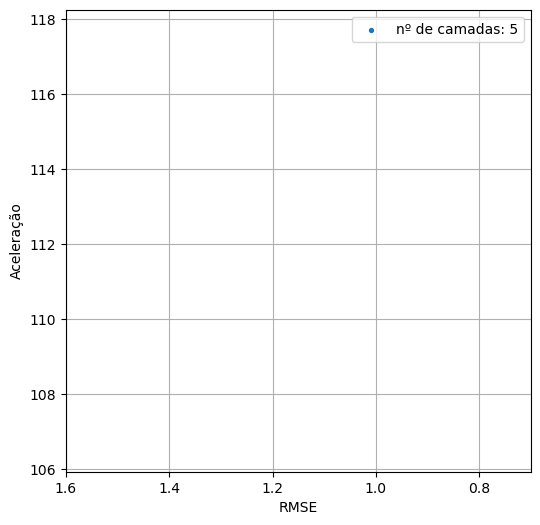

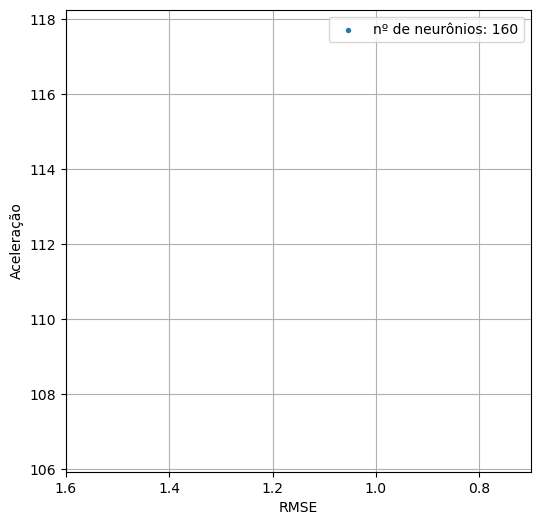

Arquitetura escolhida: SiLU--32__Tanh--32__SiLU--32__Tanh--32__SiLU--32
Best bestas:  0.9__0.9999
Erro absoluto médio 0.48872321706002064
Erro absoluto máximo 1.0386734837050238
Aceleração: 42.54323288898592 +/-0.15483596932758062
Compilation Aceleração: 0.1125265378273561 +/-0.011635150517720625
PINN Aceleração: 112.08761958734499 +/-74.96665817938917


In [5]:
x_lim = (1.6, 1.7)

# --- Gráfico 1: linhas limites em vermelho ---
fig1 = plt.figure(figsize=(6, 6))
ax1 = fig1.add_subplot(1, 1, 1)

ax1.scatter(results_df.rmse, results_df.mean_speed_up_pinn, s=4)
ax1.hlines(max(results_df.mean_speed_up_pinn), x_lim[0], x_lim[1], color="r")
ax1.hlines(min(results_df.mean_speed_up_pinn), x_lim[0], x_lim[1], color="r")
ax1.vlines(
    x_lim[1],
    min(results_df.mean_speed_up_pinn),
    max(results_df.mean_speed_up_pinn),
    color="r",
)
ax1.vlines(
    x_lim[0],
    min(results_df.mean_speed_up_pinn),
    max(results_df.mean_speed_up_pinn),
    color="r",
)

ax1.set_xlabel("RMSE")
ax1.set_ylabel("Aceleração")
ax1.grid()
plt.show()

# --- Gráfico 2: destaque para ponto de escolha ---
fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(1, 1, 1)

choice = np.intersect1d(
    np.argwhere(np.array(results_df.mean_speed_up_pinn) > 98),
    np.argwhere(np.array(results_df.rmse) < 1.7),
)[0]

ax2.scatter(results_df.rmse, results_df.mean_speed_up_pinn, s=8)
ax2.scatter(
    results_df.rmse[choice], results_df.mean_speed_up_pinn[choice], c="r", marker="*"
)
ax2.set_xlim(x_lim[0], x_lim[1])
ax2.set_xlabel("RMSE")
ax2.set_ylabel("Aceleração")
ax2.grid()
plt.show()

# --- Gráfico 3: variando número de camadas ---
fig3 = plt.figure(figsize=(6, 6))
ax3 = fig3.add_subplot(1, 1, 1)

unique_n_layers = np.unique(results_df.n_layers)
for n_layers in unique_n_layers:
    sub_df = results_df[results_df.n_layers == int(n_layers)]
    ax3.scatter(
        sub_df.rmse,
        sub_df.mean_speed_up_pinn,
        s=8,
        label=f"nº de camadas: {int(n_layers)}",
    )

ax3.set_xlabel("RMSE")
ax3.set_ylabel("Aceleração")
ax3.set_xlim(x_lim[0], 0.7)
ax3.legend()
ax3.grid()
plt.show()

# --- Gráfico 4: variando número de neurônios ---
fig4 = plt.figure(figsize=(6, 6))
ax4 = fig4.add_subplot(1, 1, 1)

unique_n_neurons = np.unique(results_df.n_neurons)
for n_neurons in unique_n_neurons:
    sub_df = results_df[results_df.n_neurons == int(n_neurons)]
    ax4.scatter(
        sub_df.rmse,
        sub_df.mean_speed_up_pinn,
        s=8,
        label=f"nº de neurônios: {int(n_neurons)}",
    )

ax4.set_xlabel("RMSE")
ax4.set_ylabel("Aceleração")
ax4.set_xlim(x_lim[0], 0.7)
ax4.legend()
ax4.grid()
plt.show()


best_model = results_df.iloc[choice]

arch_str = best_model["arch_name"]

print("Arquitetura escolhida: " + arch_str)
print("Best bestas: ", best_model["betas"])
print("Erro absoluto médio", best_model["rmse"])
print("Erro absoluto máximo", best_model["max_ae"])
print(
    "Aceleração: {} +/-{}".format(
        best_model["mean_speed_up"], best_model["std_speed_up"]
    )
)
print(
    "Compilation Aceleração: {} +/-{}".format(
        best_model["mean_speed_comp_up"], best_model["std_speed_comp_up"]
    )
)
print(
    "PINN Aceleração: {} +/-{}".format(
        best_model["mean_speed_up_pinn"], best_model["std_speed_up_pinn"]
    )
)

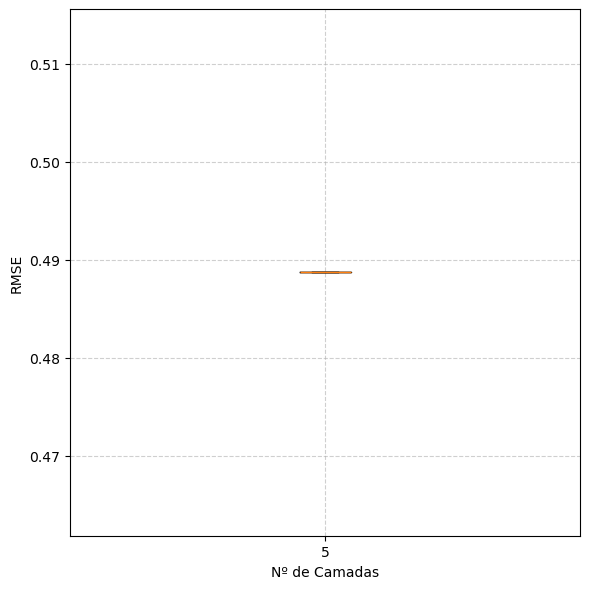

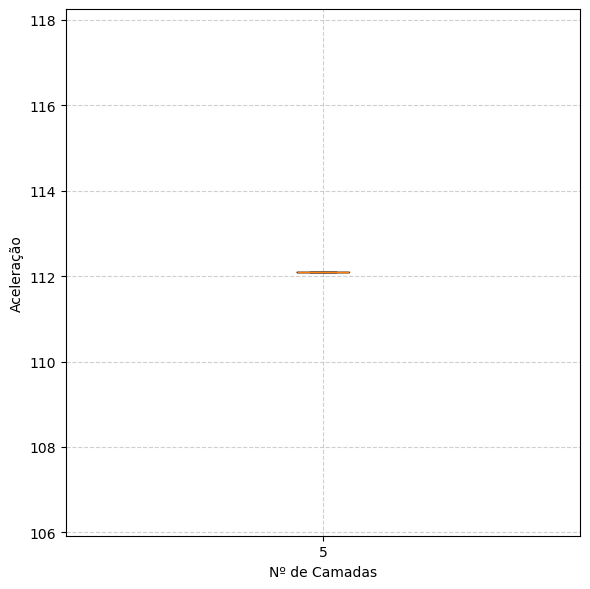

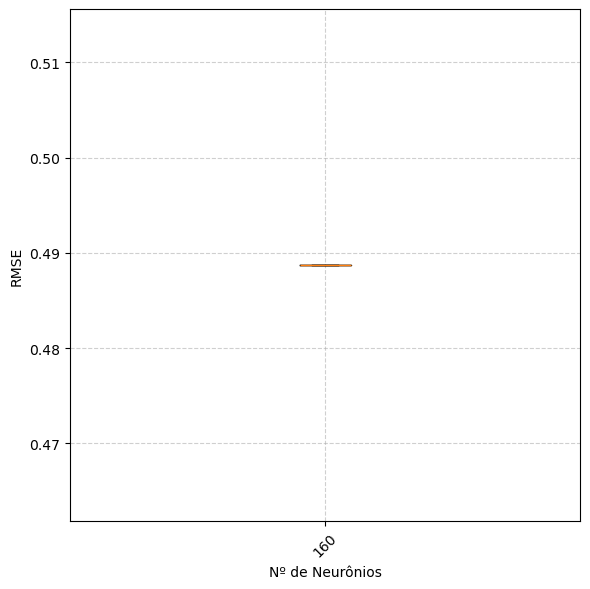

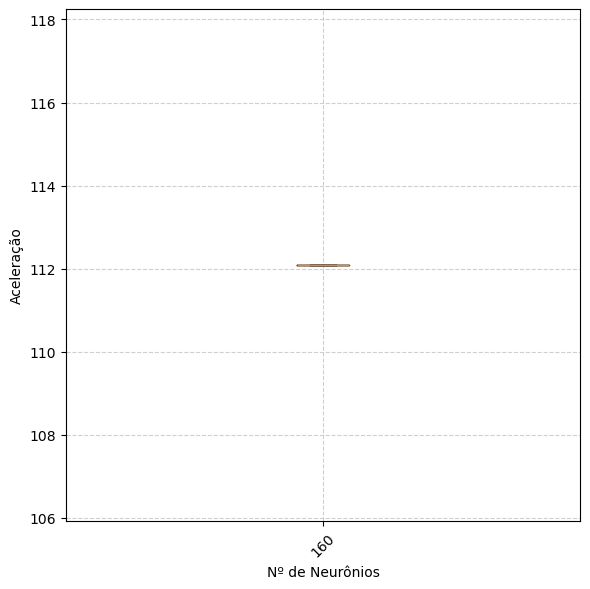

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def set_axis_style(ax, labels, xlabel, ylabel):
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.6)


# --- Gráfico 1: RMSE por nº de camadas ---
fig1, ax1 = plt.subplots(figsize=(6, 6))
unique_n_layers = np.unique(results_df.n_layers)
collection = [results_df[results_df.n_layers == n].rmse for n in unique_n_layers]
ax1.boxplot(
    collection, positions=np.arange(1, len(unique_n_layers) + 1), showfliers=False
)
set_axis_style(ax1, unique_n_layers, "Nº de Camadas", "RMSE")
plt.tight_layout()
plt.show()

# --- Gráfico 2: Speed up por nº de camadas ---
fig2, ax2 = plt.subplots(figsize=(6, 6))
collection = [
    results_df[results_df.n_layers == n].mean_speed_up_pinn for n in unique_n_layers
]
ax2.boxplot(
    collection, positions=np.arange(1, len(unique_n_layers) + 1), showfliers=False
)
set_axis_style(ax2, unique_n_layers, "Nº de Camadas", "Aceleração")
plt.tight_layout()
plt.show()

# --- Gráfico 3: RMSE por nº de neurônios ---
fig3, ax3 = plt.subplots(figsize=(6, 6))
unique_n_neurons = np.unique(results_df.n_neurons)
collection = [results_df[results_df.n_neurons == n].rmse for n in unique_n_neurons]
ax3.boxplot(
    collection, positions=np.arange(1, len(unique_n_neurons) + 1), showfliers=False
)
set_axis_style(ax3, unique_n_neurons, "Nº de Neurônios", "RMSE")
plt.setp(ax3.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

# --- Gráfico 4: Aceleração por nº de neurônios ---
fig4, ax4 = plt.subplots(figsize=(6, 6))
collection = [
    results_df[results_df.n_neurons == n].mean_speed_up_pinn for n in unique_n_neurons
]
ax4.boxplot(
    collection, positions=np.arange(1, len(unique_n_neurons) + 1), showfliers=False
)
set_axis_style(ax4, unique_n_neurons, "Nº de Neurônios", "Aceleração")
plt.setp(ax4.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

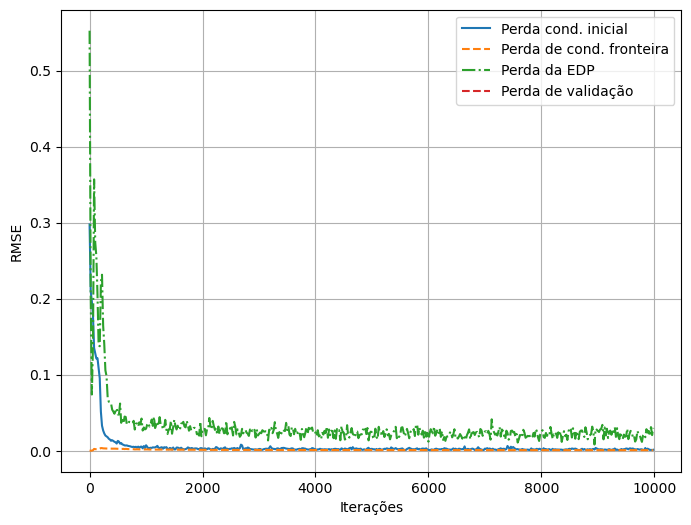

In [7]:
from plots import plot_learning_curves
import pickle as pk

with open("learning_curves/" + best_model["file"], "rb") as f:
    loss_dict = pk.load(f)

labels = [
    "Perda cond. inicial",
    "Perda de cond. fronteira",
    "Perda da EDP",
    "Perda de validação",
]

markers = [
    "-",
    "--",
    "-.",
    "--",
    "-.",
]

plot_learning_curves(loss_dict, labels, markers)

In [8]:
import pickle as pk
import json
from pinn import *

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cl_fvm, Cp_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])

size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

(
    initial_tc,
    center_x_tc,
    radius_tc,
    data_tc,
    src_tc,
    target_tc,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    size_t,
    size_x,
    center[0],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    leu_source_points,
)

Steps in time = 300
Steps in space_x = 40
Steps in space_y = 1

device: cuda


In [9]:
from plots import (
    plot_comparison,
    plot_comparison_pinn,
    plot_comparison_contour,
)

with open("pinn_sim/prediction_" + best_model["file"], "rb") as f:
    # Reading from json file
    prediction = pk.load(f)

with open("source_points/lymph_vessels.pkl", "rb") as f:
    leu_source_points = pk.load(f)

pred_pinn = prediction["pred_pinn"]

target = prediction["target"]

Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

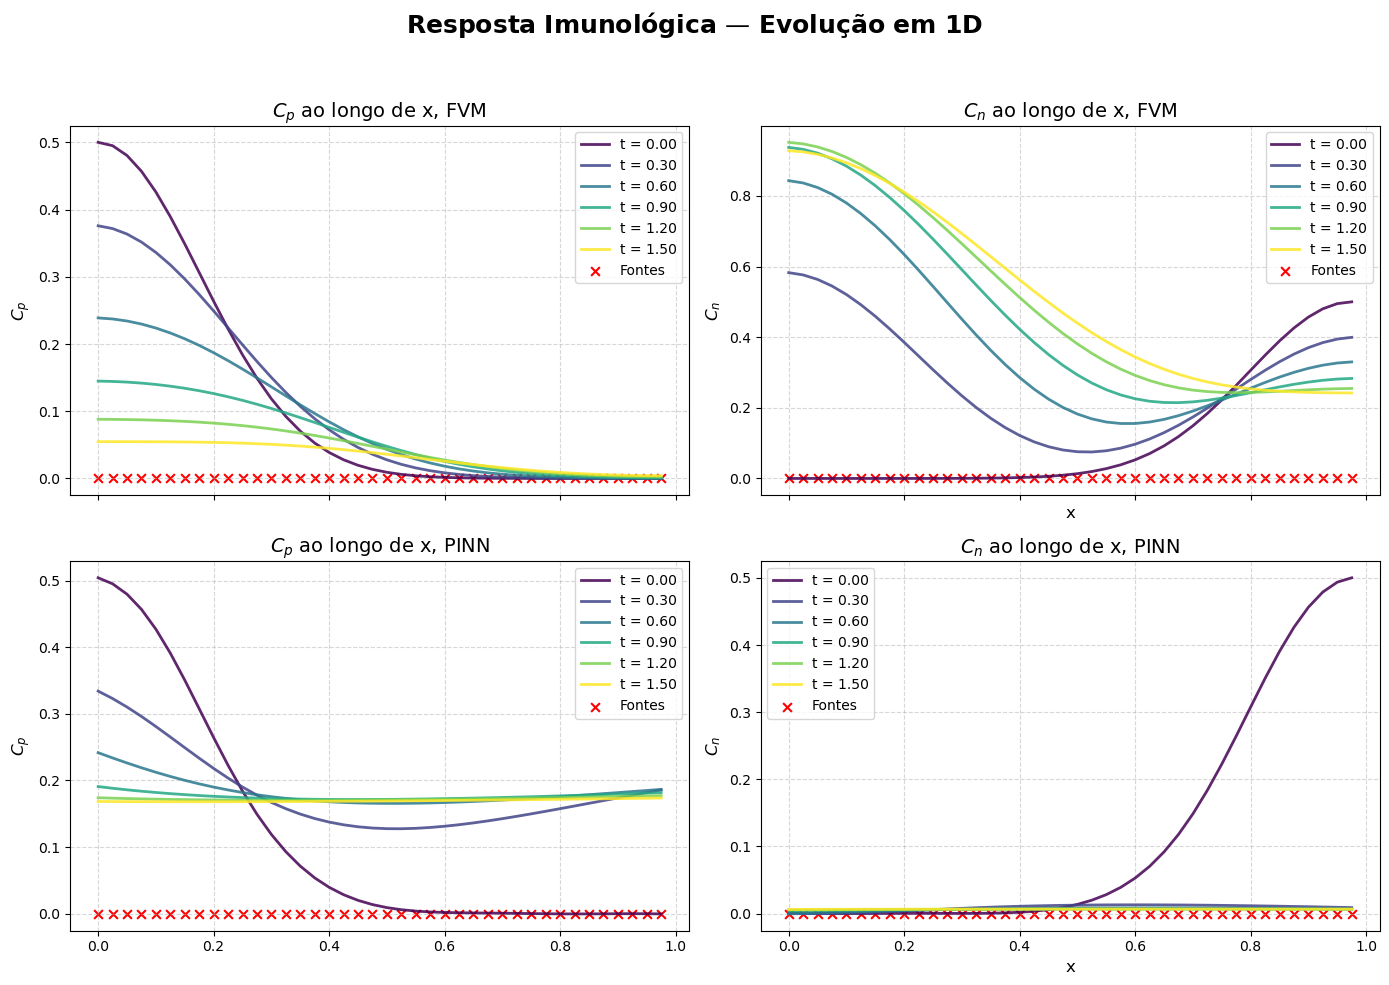

In [14]:
plot_comparison(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cl_fvm,
    Cp_fvm,
    Cl_pinn_np,
    Cp_pinn_np,
    leu_source_points,
)

## Samples analisys

In [11]:
result_list = glob("pinn_sim/comp_*")

print("numero de amostragens testadas: {}".format(len(result_list) / 2))

numero de amostragens testadas: 0.0


In [12]:
i = 0

results_dict = {}

for file in result_list:

    file_type, n_samples = file.split("/")[-1].replace(".pkl", "").split("_")[1:]

    if file_type == "metrics":
        with open(file, "rb") as f:
            aux_dict = pk.load(f)

        results_dict[i] = aux_dict

        i += 1

In [13]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index").sort_values(
    by=["n_samples"]
)[1:]

results_df.tail()

KeyError: 'n_samples'

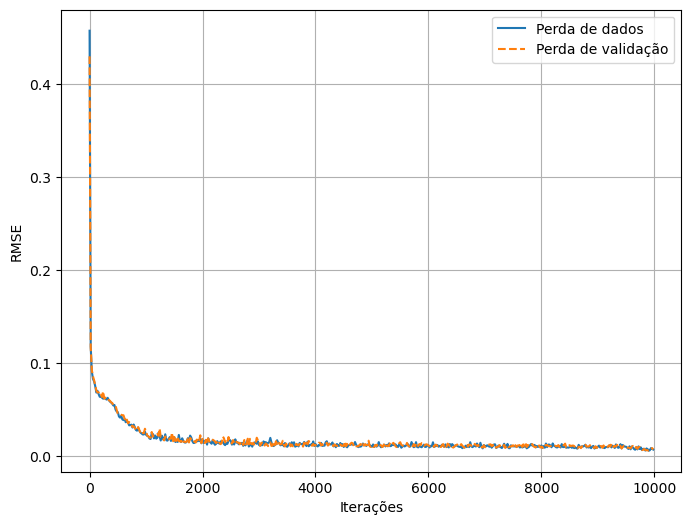

In [ ]:
import matplotlib.pyplot as plt
import pickle as pk

with open("learning_curves/comp.pkl", "rb") as f:
    loss_dict = pk.load(f)

fig = plt.figure(figsize=[8, 6])
# fig.suptitle("Curva de aprendizagem", fontsize=16)

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Iterações")
ax.set_ylabel("RMSE")

sampling_step = 20  # change this to control how many points are plotted

labels = [
    "Perda de dados",
    "Perda de validação",
]

markers = [
    "-",
    "--",
]

for loss, label, m in zip(loss_dict, labels, markers):
    sampled_x = range(0, len(loss_dict[loss]), sampling_step)
    sampled_y = loss_dict[loss][::sampling_step]

    ax.plot(
        sampled_x,
        sampled_y,
        m,
        label=label,
    )

# ax.set_yscale("log")  # uncomment if needed
ax.grid()
ax.legend()
plt.show()

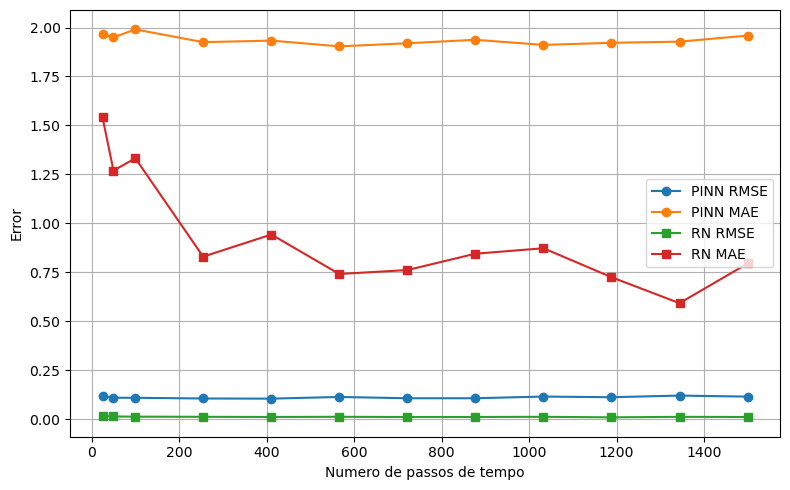

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(
    results_df["n_samples"], results_df["pinn_rmse"], marker="o", label="PINN RMSE"
)
plt.plot(results_df["n_samples"], results_df["pinn_mae"], marker="o", label="PINN MAE")
plt.plot(results_df["n_samples"], results_df["nn_rmse"], marker="s", label="RN RMSE")
plt.plot(results_df["n_samples"], results_df["nn_mae"], marker="s", label="RN MAE")
plt.xlabel("Numero de passos de tempo")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

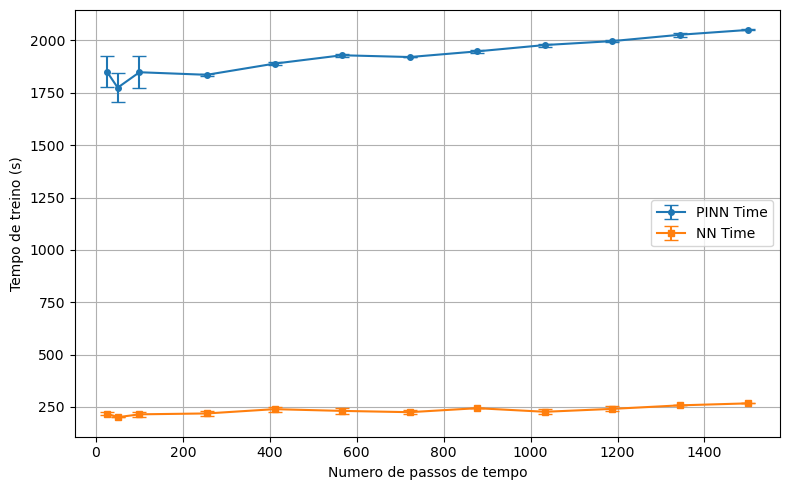

In [ ]:
# Plot
plt.figure(figsize=(8, 5))

# PINN with error bars
plt.errorbar(
    results_df["n_samples"],
    results_df["mean_pinn_time"],
    yerr=results_df["std_pinn_time"],
    fmt="-o",
    label="PINN Time",
    capsize=5,
    ms=4,
)

# NN with error bars
plt.errorbar(
    results_df["n_samples"],
    results_df["mean_nn_time"],
    yerr=results_df["std_nn_time"],
    fmt="-s",
    label="NN Time",
    capsize=5,
    ms=4,
)

# Final plot settings
plt.xlabel("Numero de passos de tempo")
plt.ylabel("Tempo de treino (s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
samples_choice = 1500

file = "pinn_sim/comp_output_{:d}.pkl".format(samples_choice)

with open(file, "rb") as f:
    choice = pk.load(f)

In [ ]:
pred_pinn = choice["pred_pinn"]
pred_nn = choice["pred_nn"]
target = choice["target"]

In [ ]:
Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

Cl_nn_device, Cp_nn_device = np.split(pred_nn, 2, axis=1)

Cl_nn_np = Cl_nn_device.reshape(Cp_fvm.shape)

Cp_nn_np = Cp_nn_device.reshape(Cp_fvm.shape)

In [ ]:
t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32)
time_plot = np.linspace(0, size_t - 1, num=60, endpoint=True, dtype=int)

source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()

import os
import numpy as np
import matplotlib.pyplot as plt

# Diretório onde as imagens serão salvas
output_dir = "anims"
os.makedirs(output_dir, exist_ok=True)

# Lista dos dados e seus rótulos
datasets = [
    (Cp_fvm, Cl_fvm, "FVM"),
    (Cp_pinn_np, Cl_pinn_np, "PINN"),
    (Cp_nn_np, Cl_nn_np, "NN"),
]

# Calcula os limites globais de Cp e Cn para cada modelo
y_limits = []  # Lista de tuplas: (cp_min, cp_max, cn_min, cn_max)
for Cp_data, Cn_data, _ in datasets:
    cp_min, cp_max = np.min(Cp_data), np.max(Cp_data)
    cn_min, cn_max = np.min(Cn_data), np.max(Cn_data)
    y_limits.append((cp_min, cp_max, cn_min, cn_max))

# Iterar sobre cada passo de tempo especificado
for time_idx, time_inst in enumerate(time_plot):
    t_val = t_np[time_inst]

    for model_idx, (Cb_data, Cn_data, model_name) in enumerate(datasets):
        cp_min, cp_max, cn_min, cn_max = y_limits[model_idx]

        for data, ylabel in zip([Cb_data, Cn_data], ["$C_p$", "$C_n$"]):
            fig, ax = plt.subplots(figsize=(6, 4))

            # Plot da curva para o instante de tempo atual
            ax.plot(
                x_np,
                data[time_inst].squeeze(),
                label=f"t = {t_val:.2f}",
                color="blue",
                linewidth=2,
                alpha=0.9,
            )

            # Plot das fontes
            ax.scatter(
                x_np[source_index],
                np.zeros(source_index.shape),
                color="red",
                label="Fontes",
                s=40,
                marker="x",
            )

            # Escala fixa com base nos valores do método
            if ylabel == "$C_p$":
                ax.set_ylim([cp_min, cp_max])
            else:
                ax.set_ylim([cn_min, cn_max])

            ax.set_xlabel("x", fontsize=12)
            ax.set_ylabel(ylabel, fontsize=12)
            ax.legend()
            ax.grid(True, linestyle="--", alpha=0.5)
            plt.tight_layout()

            # Salva a imagem
            filename = f"{output_dir}/plot_{model_name}_{ylabel.replace('$', '')}_t{time_idx}.png"
            plt.savefig(filename, dpi=300)
            plt.close(fig)

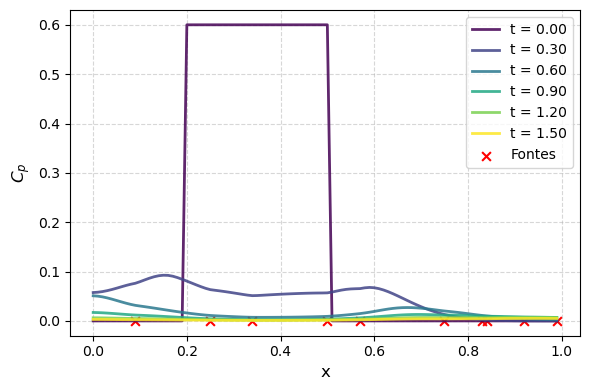

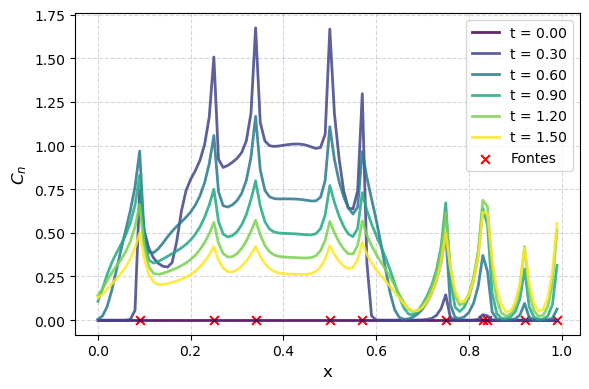

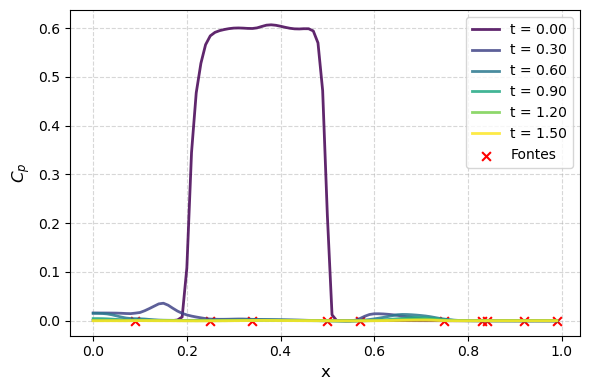

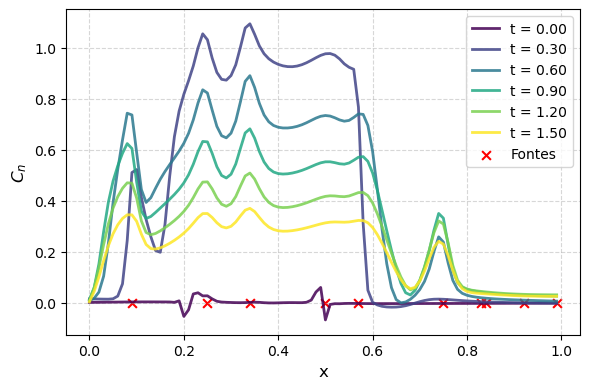

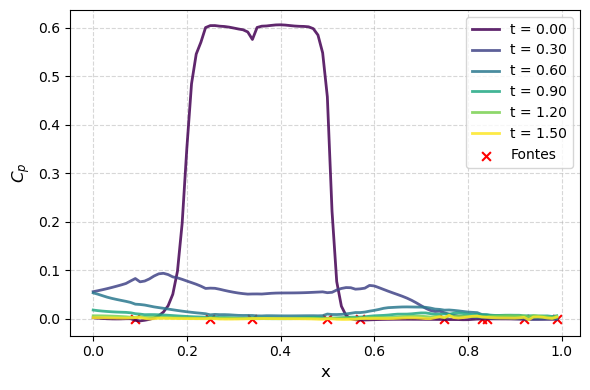

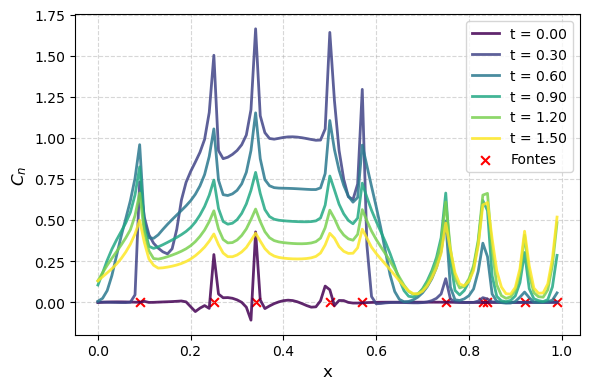

In [ ]:
t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32)
time_plot = np.linspace(0, size_t - 1, num=6, endpoint=True, dtype=int)

colors = plt.cm.viridis(np.linspace(0, 1, len(time_plot)))
source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()

# Lista dos dados e seus rótulos
datasets = [
    (Cp_fvm, Cl_fvm),
    (Cp_pinn_np, Cl_pinn_np),
    (Cp_nn_np, Cl_nn_np),
]

# Laço para cada conjunto de dados (FVM, PINN, NN)
for model_idx, (Cb_data, Cn_data) in enumerate(datasets):
    for data, ylabel in zip([Cb_data, Cn_data], ["$C_p$", "$C_n$"]):
        fig, ax = plt.subplots(figsize=(6, 4))
        for i, time_inst in enumerate(time_plot):
            ax.plot(
                x_np,
                data[time_inst].squeeze(),
                label=f"t = {t_np[time_inst]:.2f}",
                color=colors[i],
                linewidth=2,
                alpha=0.85,
            )

        ax.scatter(
            x_np[source_index],
            np.zeros(source_index.shape),
            color="red",
            label="Fontes",
            s=40,
            marker="x",
        )

        ax.set_xlabel("x", fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

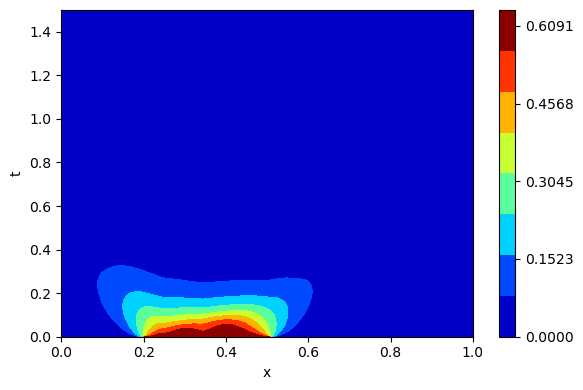

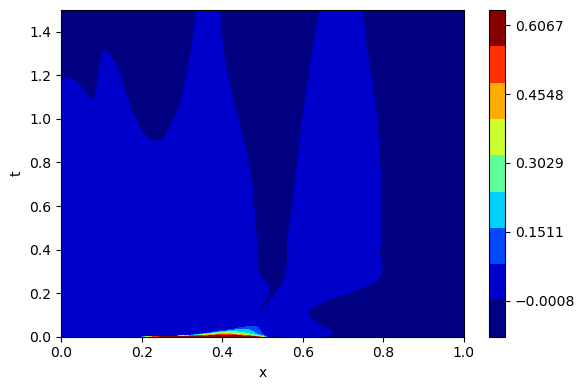

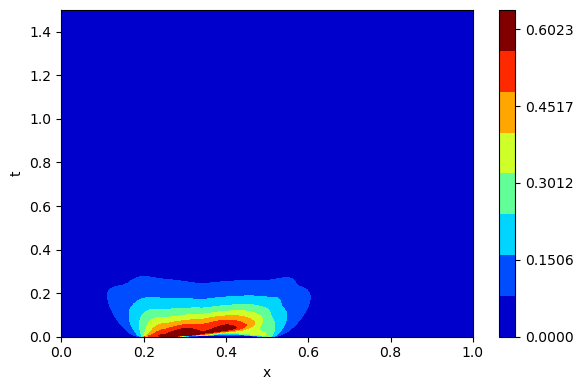

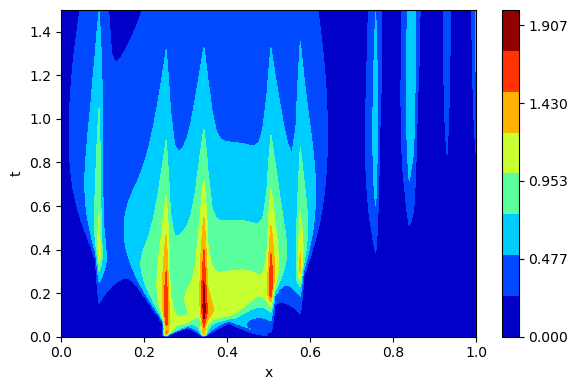

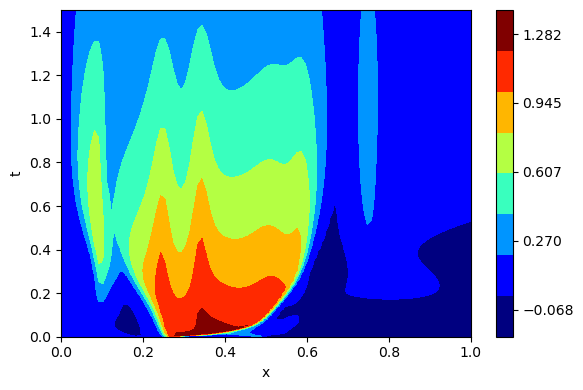

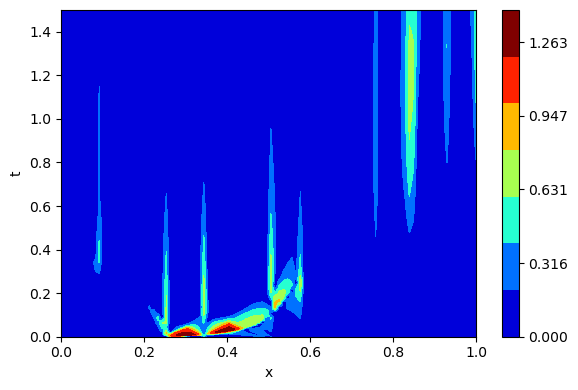

In [ ]:
titles = [
    "$C_p$ FVM",
    "$C_p$ PINN",
    "Erro Absoluto - $C_p$",
    "$C_l$ FVM",
    "$C_l$ PINN",
    "Erro Absoluto - $C_l$",
]

plot_comparison_contour(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cp_target_np,
    Cl_target_np,
    Cp_pinn_np,
    Cl_pinn_np,
)

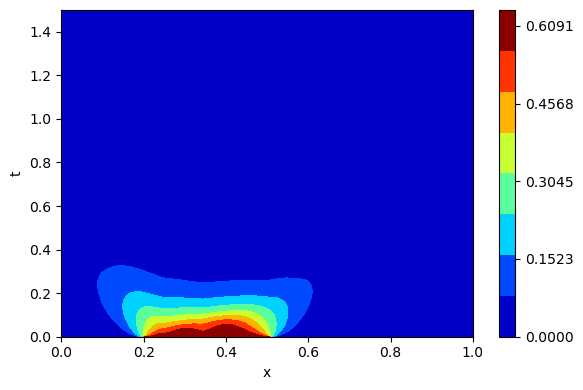

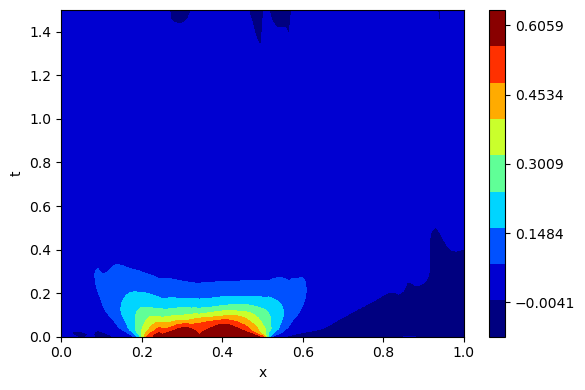

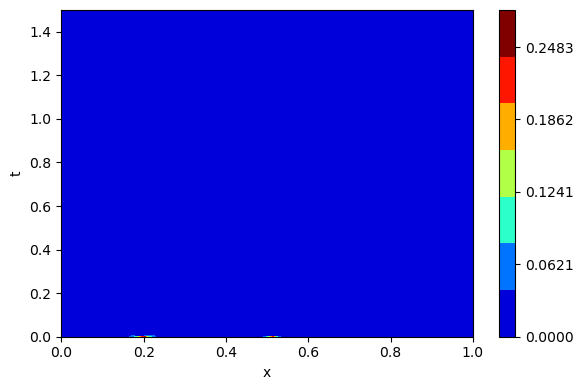

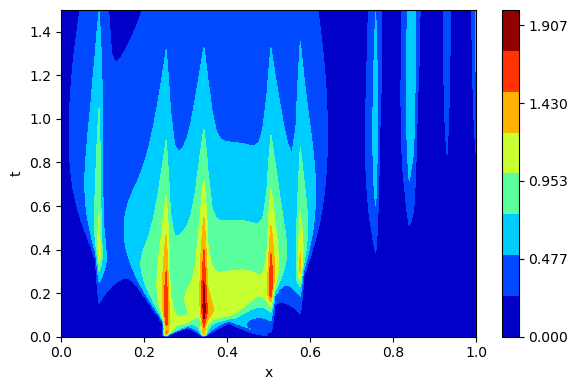

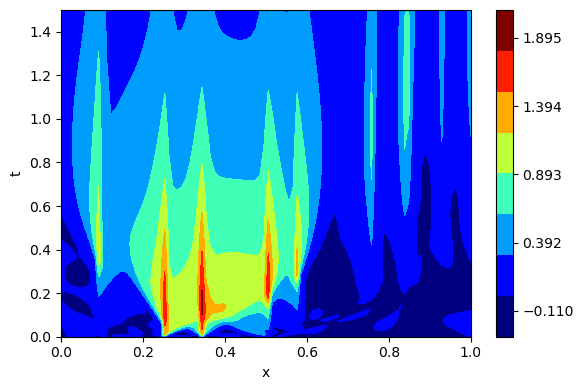

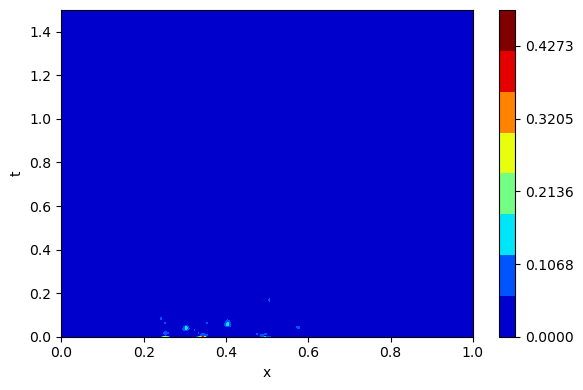

In [ ]:
titles = [
    "$C_p$ FVM",
    "$C_p$ RN",
    "Erro Absoluto - $C_p$",
    "$C_l$ FVM",
    "$C_l$ RN",
    "Erro Absoluto - $C_l$",
]

plot_comparison_contour(
    size_t, size_x, t_dom, x_dom, Cp_target_np, Cl_target_np, Cp_nn_np, Cl_nn_np
)